<a href="https://colab.research.google.com/github/ruthtsai/Deep-Generative-Models/blob/main/HW1_VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 準備環境與資料

In [16]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# 設定 OpenMP 環境變數以避免 KMP 警告/錯誤
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


# 建立資料目錄
DATA_DIR = './data/MNIST/raw'
os.makedirs(DATA_DIR, exist_ok=True)

# 下載 MNIST 原始檔（mirror by fgnt）
urls = {
'train-images': 'https://raw.githubusercontent.com/fgnt/mnist/master/train-images-idx3-ubyte.gz',
'train-labels': 'https://raw.githubusercontent.com/fgnt/mnist/master/train-labels-idx1-ubyte.gz',
't10k-images': 'https://raw.githubusercontent.com/fgnt/mnist/master/t10k-images-idx3-ubyte.gz',
't10k-labels': 'https://raw.githubusercontent.com/fgnt/mnist/master/t10k-labels-idx1-ubyte.gz'
}


# 下載函式
def download_file(url, dest_path):
  if os.path.exists(dest_path):
    print(f"已存在: {dest_path}")
    return
  print(f"下載: {url} -> {dest_path}")
  # 先用 wget
  wget_cmd = f"wget -q -O {dest_path} {url}"
  ret = os.system(wget_cmd)


# 執行下載
for name, url in urls.items():
  dest = os.path.join(DATA_DIR, url.split('/')[-1])
  download_file(url, dest)

def load_mnist_images(filename):
    path = os.path.join(DATA_DIR, filename)
    with gzip.open(path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28*28) / 255.0
        return data.astype(np.float32)

def load_mnist_labels(filename):
    path = os.path.join(DATA_DIR, filename)
    with gzip.open(path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

# 載入訓練和測試資料
x_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
x_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

# 建立 DataLoader
batch_size = 128
train_loader = DataLoader(TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
                         batch_size=batch_size, shuffle=False)

已存在: ./data/MNIST/raw/train-images-idx3-ubyte.gz
已存在: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
已存在: ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
已存在: ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


2. 模型設計 (VAE)

In [14]:
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
    super(VAE, self).__init__()
    # Encoder
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)       # 均值
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)   # 對數方差

    # Decoder
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, input_dim)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def encode(self, x):
    h = self.relu(self.fc1(x))
    return self.fc_mu(h), self.fc_logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h = self.relu(self.fc3(z))
    return self.sigmoid(self.fc4(h))

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    recon_x = self.decode(z)
    return recon_x, mu, logvar

# 初始化模型與優化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

3. 訓練與測試：訓練設定與函數 測試重建與圖像顯示

Epoch 1, Average loss: 163.1963
Epoch 2, Average loss: 121.0383
Epoch 3, Average loss: 114.2028
Epoch 4, Average loss: 111.2818
Epoch 5, Average loss: 109.5062
訓練完成！


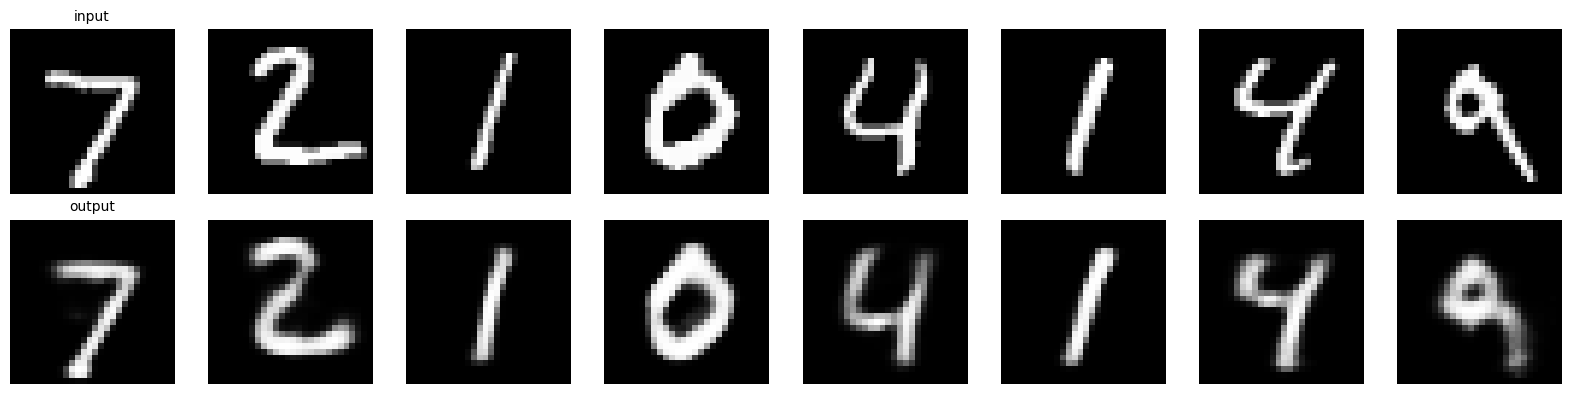

已儲存重建圖檔 reconstruction.png


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 損失函數: BCE + KL divergence
def loss_function(recon_x, x, mu, logvar):
    # BCE loss + KL divergence
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 訓練模型
epochs = 5
model.train()
for epoch in range(1, epochs+1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average loss: {avg_loss:.4f}')
print("訓練完成！")

# 圖像顯示
model.eval()
with torch.no_grad():
    test_samples = x_test[:8]
    test_tensor = torch.tensor(test_samples).to(device)
    recon_samples, _, _ = model(test_tensor)
    recon_samples = recon_samples.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(16,4), gridspec_kw={'height_ratios':[1,1]})
# 上排：input 圖
for i in range(8):
    axes[0,i].imshow(test_samples[i].reshape(28,28), cmap='gray')
    axes[0,0].set_title('input', fontsize=10)
    axes[0,i].axis('off')

# 下排：output 圖
for i in range(8):
    axes[1,i].imshow(recon_samples[i].reshape(28,28), cmap='gray')
    axes[1,0].set_title('output', fontsize=10)
    axes[1,i].axis('off')

plt.tight_layout()
plt.savefig('reconstruction.png')
plt.show()


print("已儲存重建圖檔 reconstruction.png")